In [101]:
import pandas as pd
import datetime

# 元となる脆弱性のデータ

In [102]:
vul_origin_data = pd.read_csv("./../vulnerability/npm_vul_data_before_2019_last_100.csv",delimiter=",")
vul_origin_data

,vulnerability_name,package_name,version_range,published_at,project_id
0,Denial of Service in http-proxy-agent,http-proxy-agent,>=0 <2.1.0,2019-06-11T16:16:07Z,158021
1,Rate Limiting Bypass in express-brute,express-brute,>=0,2019-06-07T21:01:53Z,146016
2,express-basic-auth Timing Attack due to native...,express-basic-auth,>=0 <1.1.7,2019-06-06T15:32:32Z,1727860
3,Command Injection in command-exists,command-exists,>=0 <1.2.4,2019-06-03T17:31:26Z,137198
4,Command Injection in opencv,opencv,>=0 <6.1.0,2019-06-04T20:11:44Z,178575
...,...,...,...,...,...
95,Cross-Site Scripting in serialize-javascript,serialize-javascript,>=0 <2.1.1,2019-12-05T18:44:37Z,312181
96,Malicious Package in lodahs,lodahs,>=0.0.1,2019-12-16T19:29:33Z,3784246
97,Arbitrary File Write in npm,npm,>=0 <6.13.3,2019-12-13T15:39:19Z,177357
98,Validation bypass is possible in Json Pattern ...,jpv,>=0 <2.1.1,2019-12-04T21:25:28Z,2705971


## 重複した脆弱性データがないか確認

In [103]:
vul_origin_data.groupby(["vulnerability_name", "package_name", "project_id"]).size().sort_values(ascending=False)

vulnerability_name                                                  package_name                 project_id
Arbitrary Code Execution in eslint-utils                            eslint-utils                 2775836       1
Prototype Pollution in lodash                                       lodash.template              167376        1
Regular Expression Denial of Service in underscore.string           underscore.string            326672        1
Regular Expression Denial of Service in remarkable                  remarkable                   306701        1
Regular Expression Denial of Service in csv-parse                   csv-parse                    276738        1
                                                                                                              ..
Denial of Service in mem                                            mem                          294767        1
Denial of Service in http-proxy-agent                               http-proxy-agent             1580

# 脆弱性影響の解析後データを分析

In [104]:
vul_data = pd.read_csv("./affected_packages_npm_with_all.csv",delimiter=",")
vul_data

,project_id,vul_project_id,vul_start_datetime,vul_end_datetime,vul_start_timestamp,vul_end_timestamp,compliantType,vul_start_dependency_compliant,vul_start_version,vul_deps,vul_total_count
0,311142,177357,2015-02-17 12:02:16 +0000 UTC,2023-01-22 14:51:06.204046 +0900 JST m=+8.1196...,1424174536,1674366666,1,^2.5.0,2.6.0,0,1
1,606184,177357,2015-02-17 15:47:06 +0000 UTC,2023-01-22 14:51:06.234634 +0900 JST m=+8.1502...,1424188026,1674366666,1,^2.5.1,2.6.0,0,1
2,509282,177357,2015-02-13 22:49:41 +0000 UTC,2023-01-22 14:51:06.261454 +0900 JST m=+8.1770...,1423867781,1674366666,1,^2.2.0,2.6.0,0,1
3,268907,177357,2014-04-24 21:21:27 +0000 UTC,2023-01-22 14:51:06.354896 +0900 JST m=+8.2704...,1398374487,1674366666,3,1.4.4,1.4.4,0,1
4,160295,177357,2014-04-24 22:55:46 +0000 UTC,2023-01-22 14:51:06.558397 +0900 JST m=+8.4739...,1398380146,1674366666,1,^1.4.6,1.4.7,0,1
...,...,...,...,...,...,...,...,...,...,...,...
70729,2652409,158021,2018-02-12 18:07:46 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1518458866,1520120980,1,^2.0.0,2.0.0,0,1
70730,2677875,158021,2018-03-01 09:33:16 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1519896796,1520120980,1,^2.0.0,2.0.0,0,1
70731,2184796,158021,2017-12-20 23:22:40 +0000 UTC,2018-03-03 23:49:40 +0000 UTC,1513812160,1520120980,1,^2.0.0,2.0.0,0,1
70732,3183225,158021,2018-07-24 07:35:20 +0000 UTC,2023-01-22 15:21:14.475495 +0900 JST m=+1816.4...,1532417720,1674368474,3,2.0.0,2.0.0,0,1


## 影響を与えたパッケージ数のランキング

In [105]:
vul_data.groupby("vul_project_id").size().sort_values(ascending=False)

vul_project_id
177357     17616
288506     11352
295772      6864
127732      4667
272771      4020
           ...  
945180         1
171065         1
702847         1
3655233        1
4433945        1
Length: 82, dtype: int64

## 影響を受けた期間を計算

- 脆弱性受け終わりの時刻が現在時刻(2023年1月1日)付近であれば、脆弱性受け終わりの時刻を'2020-01-12 00:00:00'に上書きする
    - データセットの構築時の最新時刻に揃える
    - データセット: https://libraries.io/data

In [106]:
parsed_datetime = datetime.datetime(2023, 1, 1, 0, 0, 0, 0)
vul_end_last_datetime = datetime.datetime(2020, 1, 12, 0, 0, 0, 0)

vul_data["vul_end_datetime"] = vul_data["vul_end_datetime"].where(vul_data["vul_end_timestamp"] < parsed_datetime.timestamp(), vul_end_last_datetime.strftime('%Y-%m-%d %H:%M:%S'))
vul_data["vul_end_timestamp"] = vul_data["vul_end_timestamp"].where(vul_data["vul_end_timestamp"] < parsed_datetime.timestamp(), vul_end_last_datetime.timestamp())
vul_data["vul_months"] = (vul_data["vul_end_timestamp"] - vul_data["vul_start_timestamp"]) / (3600 * 24 * 30)
vul_data
vul_data["status"] = vul_data["vul_end_timestamp"] < vul_end_last_datetime.timestamp()

## データの分布


### 脆弱性の存続期間

<AxesSubplot: >

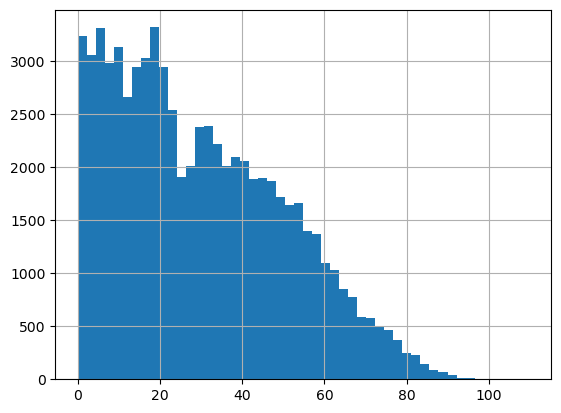

In [107]:
vul_data["vul_months"].hist(bins=50)

### semver準拠タイプごとの影響を受けたパッケージ数

- 1: (本番開発リリース)準拠している
- 2: (本番開発リリース)semverより緩い制約
- 3: (本番開発リリース)semverより厳しい制約
- 4: (初期開発リリース)準拠している
- 5: (初期開発リリース)semverより緩い制約

In [108]:
vul_data.groupby("compliantType").size()

compliantType
1    51279
2     2533
3    11609
4      648
5     4665
dtype: int64

# サバイバル分析

- ドキュメント: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.nonparametric.kaplan_meier_estimator.html
    - Kaplan-Meier推定
        - https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%97%E3%83%A9%E3%83%B3%EF%BC%9D%E3%83%9E%E3%82%A4%E3%83%A4%E3%83%BC%E6%8E%A8%E5%AE%9A%E9%87%8F
    - 打ち切りデータもあってよい

In [109]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import numpy as np

In [110]:
vul_data_compliant = vul_data[vul_data["compliantType"] == 1]
vul_data_permissive = vul_data[vul_data["compliantType"] == 2]
vul_data_restrictive = vul_data[vul_data["compliantType"] == 3]

### 生存関数

- 期間が長くなっても、Compliantな脆弱性が他に比べて生き残っている

Text(0.5, 0, 'time $t$')

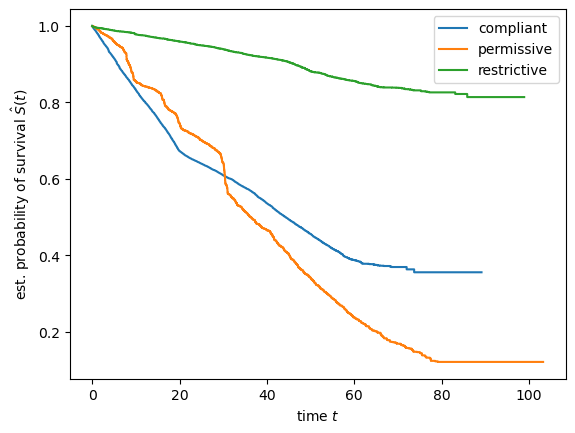

In [111]:
cph_compliant = CoxPHFitter()
cph_compliant.fit(pd.concat([vul_data_compliant["vul_months"], vul_data_compliant["status"].map(lambda x: 1 if x else 0),
                             # vul_data_compliant["project_id"]
                             ], axis=1), "vul_months", "status",
                  # weights_col="project_id",
                  robust=True)
survival_f_compliant = cph_compliant.predict_survival_function(np.arange(0, 100, 1000))


cph_permissive = CoxPHFitter()
cph_permissive.fit(pd.concat([vul_data_permissive["vul_months"], vul_data_permissive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_permissive = cph_permissive.predict_survival_function(np.arange(0, 100, 1000))

cph_restrictive = CoxPHFitter()
cph_restrictive.fit(pd.concat([vul_data_restrictive["vul_months"], vul_data_restrictive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_restrictive = cph_restrictive.predict_survival_function(np.arange(0, 100, 1000))


plt.step(survival_f_compliant.index, survival_f_compliant[0], where="post", label="compliant")
plt.step(survival_f_permissive.index, survival_f_permissive[0], where="post", label="permissive")
plt.step(survival_f_restrictive.index, survival_f_restrictive[0], where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Text(0.5, 0, 'time $t$ [month]')

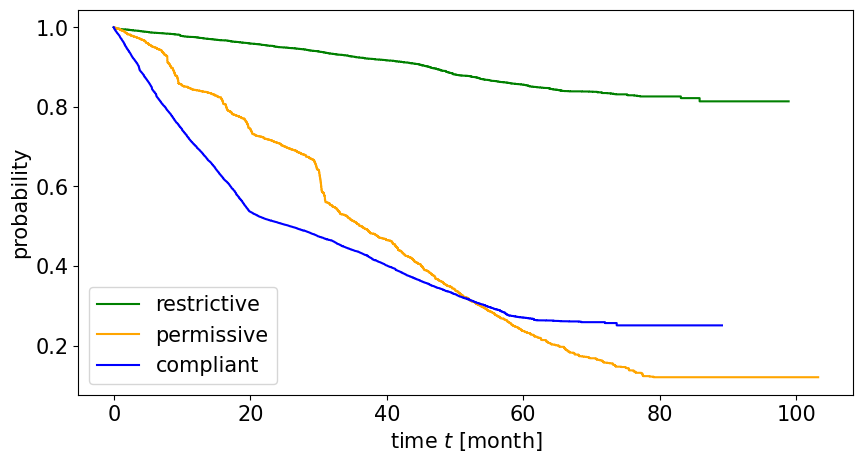

In [138]:
cph_compliant = CoxPHFitter()
cph_compliant.fit(pd.concat([vul_data_compliant["vul_months"], vul_data_compliant["status"].map(lambda x: 1 if x else 0),
                             vul_data_compliant["project_id"]
                             ], axis=1), "vul_months", "status",
                  weights_col="project_id",
                  robust=True)
survival_f_compliant = cph_compliant.predict_survival_function(np.arange(0, 100, 1000))


cph_permissive = CoxPHFitter()
cph_permissive.fit(pd.concat([vul_data_permissive["vul_months"], vul_data_permissive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_permissive = cph_permissive.predict_survival_function(np.arange(0, 100, 1000))

cph_restrictive = CoxPHFitter()
cph_restrictive.fit(pd.concat([vul_data_restrictive["vul_months"], vul_data_restrictive["status"].map(lambda x: 1 if x else 0)], axis=1), "vul_months", "status", robust=True)
survival_f_restrictive = cph_restrictive.predict_survival_function(np.arange(0, 100, 1000))

plt.rcParams["font.size"] = 15
plt.figure(figsize=[10, 5])
plt.step(survival_f_restrictive.index, survival_f_restrictive[0], where="post", label="restrictive", color="green")
plt.step(survival_f_permissive.index, survival_f_permissive[0], where="post", label="permissive", color="orange")
plt.step(survival_f_compliant.index, survival_f_compliant[0], where="post", label="compliant", color="blue")

plt.legend()

plt.ylabel("probability")
plt.xlabel("time $t$ [month]")

## 準拠タイプごとに脆弱性影響の生存期間を分析

### Compliant

In [113]:
vul_data_compliant["vul_months"].describe()

count    51279.000000
mean        26.372982
std         18.076254
min         -0.037858
25%         10.864657
50%         22.579253
75%         40.334881
max         89.130787
Name: vul_months, dtype: float64

<AxesSubplot: >

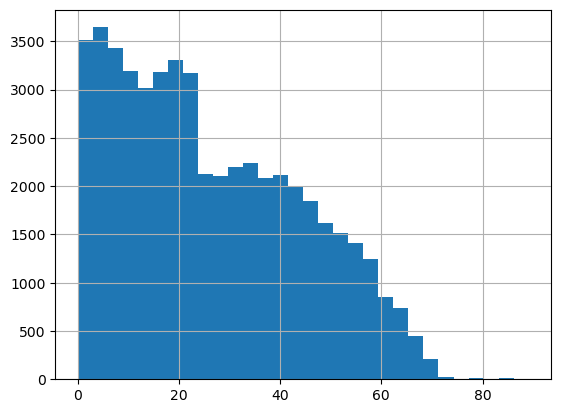

In [114]:
vul_data_compliant["vul_months"].hist(bins=30)

### Permissive

- Compliantより生存期間が長い
    - なんで？

In [115]:
vul_data_permissive["vul_months"].describe()

count    2533.000000
mean       35.489409
std        22.105035
min         0.027702
25%        17.296706
50%        31.481826
75%        51.005782
max       103.234620
Name: vul_months, dtype: float64

<AxesSubplot: >

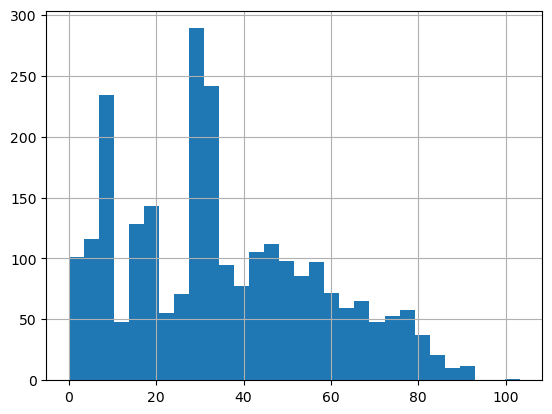

In [116]:
vul_data_permissive["vul_months"].hist(bins=30)

### Restrictive

<AxesSubplot: >

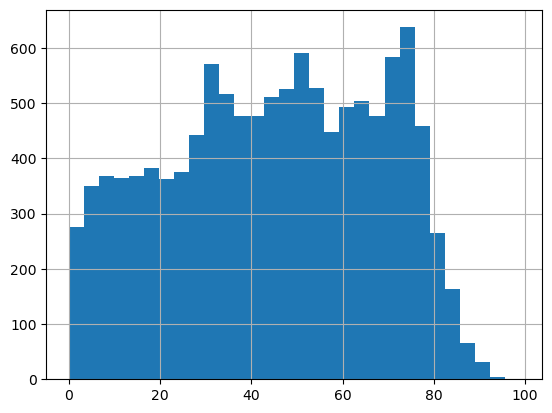

In [117]:
vul_data_restrictive["vul_months"].hist(bins=30)

In [118]:
vul_data_restrictive["vul_months"].describe()

count    11609.000000
mean        44.778663
std         23.062083
min         -0.035787
25%         26.898292
50%         45.979956
75%         64.427721
max         98.903399
Name: vul_months, dtype: float64

<AxesSubplot: >

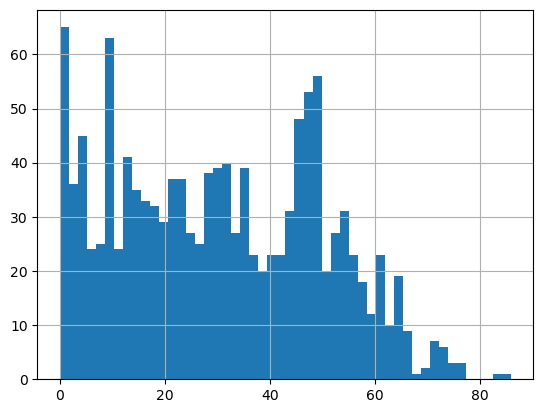

In [119]:
vul_data_restrictive["vul_months"][vul_data_restrictive["vul_end_timestamp"] < vul_end_last_datetime.timestamp()].hist(bins=50)